In [65]:
#import
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt
import time

In [66]:
#defining necessary parameters

#phisical parameters
global k_pr, m, e, e0, k, n0, t0, L0, T0, E0, c, six, two, one, half, four, set_rel_err, eight, sixteen, mu, three, twelve, oneAhalf,zero
zero=np.float64(0.)
oneAhalf = np.float64(1.5)
three = np.float64(3.)
sixteen = np.float64(16.)
set_rel_err= np.float64(1e-6)
eight = np.float64(8.)
one = np.float64(1.)
six = np.float64(6.)
two = np.float64(2.)
half = np.float64(0.5)
four = np.float64(4.)
twelve = np.float64(12.)

k_pr = np.float64(8.9875517873681764e9)
m = np.zeros(6)
m[0] = np.float64(9.1093821545E-31)
e = np.float64(1.60217648740E-19)
m[1] = np.float64(1.66053878283E-27)*np.float64(39.948)
m[3] = m[1]-m[0]
e0 = np.float64(8.854187817e-12)
k = np.float64(1.380650424E-23)

m[2]=np.float64(1.66053878283E-27)*np.float64(55.845)
m[4]=m[2]-m[0]
m[5]=m[4]-m[0]

mu = np.zeros([6,6])

for i in range(6):
    for j in range(6):
    
        mu[i,j] = m[i]*m[j]/(m[i]+m[j])

#normalizing parameters
n0=np.float64(1e23)
L0=np.float64(1e-4)
v0=np.float64(1000)
T0=one
t0=L0/v0
j0=n0*v0*e
E0=T0/L0
c = np.zeros(6)
c[:]=np.sqrt(e*T0/m[:])/v0


In [67]:
#set of functions

def set_nonl_grid(lenght, xN, coef):
    
    #lenght - [m]
    # xN - number of cells
    xL=np.float64(0.)
    xR=xL+(lenght/L0)
    H=xR
    
    #uniformly distributed parameter
    ksi = np.zeros(xN+1)
    
    for i in range(np.int(xN)):
        
        ksi[i+1] = ksi[i] + one/xN
            
    tmpr=((coef+one)/(coef-one))**(one-ksi)
    #current x has 1001 points!!!! - the edges
    x=H*(coef+one-(coef-one)*tmpr)/(one+tmpr)
    
    #size of each cell
    dx=(x[1:xN+1]-x[0:xN])
    
    #now x - array of coordinates of cells
    x = np.zeros(xN)
    x[0] = xL+half*dx[0]
    
    for i in range(dx.size-1):
        
        x[i+1] = x[i] + half*(dx[i+1]+dx[i])
        
    return x, dx

def set_w(dx):

    xN = dx.size
    
    #%линейная двухточечная аппроксимация нелинейной сетки
    w_r = dx[0:xN-1]/(dx[0:xN-1]+dx[1:xN])                        #    !линейная аппроксимация внутри области П= mass_r(1)*П2+mass_l(1)*П1; П1,П2-значения в ячейках П-между ячейками
    w_l = dx[1:xN]/(dx[0:xN-1]+dx[1:xN])

    we_l = np.zeros(2)
    we_r = np.zeros(2)
    we_r[0]=-(dx[xN-1]/(dx[xN-2]+dx[xN-1]))                             #  !линейная аппроксимация на правой границе области П= edge_r(1)*П1+edge_r(2)*П2; П1,П2-значения в ячейках П-на правая грань
    we_r[1]=((dx[xN-2]+two*dx[xN-1])/(dx[xN-2]+dx[xN-1])) 

    we_l[0] = (two*dx[0]+dx[1])/(dx[0]+dx[1])                       # !линейная аппроксимация на левой границе области П= edge_l(1)*П1+edge_l(2)*П2; П1,П2-значения в ячейках П-на левой грани
    we_l[1] = -dx[0]/(dx[0]+dx[1])

    
    return w_r, w_l, we_r, we_l

def gen_dx_w(x):
    
    dx = np.zeros(x.shape)
    
    dx[0] = two*x[0]
    
    for i in range(1, x.size):
        
        dx[i] = two*(x[i] - x[i-1] - half*dx[i-1])
    
#     print dx[:10]
    
    w_r, w_l, we_r, we_l = set_w(dx)

    return dx, w_r, w_l, we_r, we_l

In [68]:


def Ion_Rec_Ar_Fe(Te):
    
#     work in range 0.2 - 3 eV
    x = np.log(Te)

#     for t0 = 1e-7 and n =1e23 T0 = 1
#     Ar0
    p_Ar = np.zeros(7)
    p_Ar[0] = -np.float64(0.3951)
    p_Ar[1] = np.float64(0.3388)
    p_Ar[2] = -np.float64(0.03006)
    p_Ar[3] = np.float64(1.718)
    p_Ar[4] = -np.float64(5.701)
    p_Ar[5] = np.float64(12.49)
    p_Ar[6] = -np.float64(6.908)
    
    
#     1 % - relative error approximation
    
    I_Ar = np.exp(sum(np.array([p_Ar[i]*(x**(six-i)) for i in range(p_Ar.size)])))
    
    p_Ar[0] = -np.float64(0.3891)
    p_Ar[1] = np.float64(0.2566)
    p_Ar[2] = np.float64(0.9171)
    p_Ar[3] = -np.float64(0.6377)
    p_Ar[4] = np.float64(2.212)
    p_Ar[5] = -np.float64(4.865)
    p_Ar[6] = -np.float64(56.85)
    
    
    R_Ar = np.exp(sum(np.array([p_Ar[i]*x**(six-i) for i in range(p_Ar.size)])))
    
#     Fe0
    p_Fe = np.zeros(7)
    p_Fe[0] = -np.float64(0.01412)
    p_Fe[1] = np.float64(0.06936)
    p_Fe[2] = -np.float64(0.3241)
    p_Fe[3] = np.float64(1.315)
    p_Fe[4] = -np.float64(3.953)
    p_Fe[5] = np.float64(8.403)
    p_Fe[6] = -np.float64(1.898)
    
    
#     1 % - relative error approximation
    
    I_Fe =  np.exp(sum(np.array([p_Fe[i]*x**(six-i) for i in range(p_Ar.size)])))
    
    
    p_Fe[0] = np.float64(0.0131)
    p_Fe[1] = np.float64(0.08291)
    p_Fe[2] = np.float64(0.01917)
    p_Fe[3] = -np.float64(0.324 )
    p_Fe[4] = -np.float64(0.0791)
    p_Fe[5] = -np.float64(0.4089)
    p_Fe[6] = -np.float64(58.03)
    
    
    R_Fe = np.exp(sum(np.array([p_Fe[i]*x**(six-i) for i in range(p_Ar.size)])))
    
    
#     Fe1
    p_Fe[0] = -np.float64(0.02892)
    p_Fe[1] = np.float64(0.1421)
    p_Fe[2] = -np.float64(0.6638)  
    p_Fe[3] = np.float64(2.693)
    p_Fe[4] = -np.float64(8.098)
    p_Fe[5] = np.float64(16.69)
    p_Fe[6] = -np.float64(10.9)
    
    
#     1 % - relative error approximation
    
    I_Fe1 = np.exp(sum(np.array([p_Fe[i]*x**(six-i) for i in range(p_Ar.size)])))
    
    
    p_Fe[0] = -np.float64(0.007245)
    p_Fe[1] = -np.float64(0.00883)
    p_Fe[2] = np.float64(0.02286)
    p_Fe[3] = -np.float64(0.002405)
    p_Fe[4] = -np.float64(0.09593)
    p_Fe[5] = -np.float64(0.7813)
    p_Fe[6] = -np.float64(57.78)
    
    R_Fe1 = np.exp(sum(np.array([p_Fe[i]*x**(six-i) for i in range(p_Ar.size)])))

#     dimentionless output
    return I_Ar, R_Ar*n0, I_Fe, R_Fe*n0, I_Fe1, R_Fe1*n0

def Def_n(P,j,gamma,Th,Te):

    alpha1, beta1, alpha2, beta2, alpha3, beta3 = Ion_Rec_Ar_Fe(Te)

    S1=alpha1/beta1

    S2=alpha2/beta2

    S3=alpha3/beta3
    
    stat_sys = lambda x: P-x*Te-(Th/gamma)*(x/( (((one/gamma)-one)/((x/S1)+one))+(((x/S3)+np.float64(2)) / (one+(x/S3)+(x*x/(S2*S3)))) ))
    
    n_1_it = spo.fsolve(stat_sys, x0 = 0.5*P, xtol = 1e-7, )
    
    n_1 = n_1_it[-1]
    n_6=n_1/( (((one/gamma)-one)/((n_1/S1)+one))*(one+(n_1/S3)+(n_1*n_1/(S2*S3)))+((n_1/S3)+np.float64(2)) )
    
    n_5=n_1*n_6/S3          
    n_3=n_1*n_5/S2             
    n_4=n_1-n_5-two*n_6
    n_2=n_1*n_4/S1

    
    return n_1, n_2, n_3, n_4, n_5, n_6

In [69]:
def rad_Deb(n1, n4, n5, n6, Th, T1):

    return (((n4/Th)+(n5/Th)+(four*n6/Th)+(n1/T1))*(n0*e/(T0*e0)))**(-half)

def freq(Th, T1, rd):
    
    nu = np.zeros([6,6,T1.size])
    
    #12
    tmpre1=np.array([1.80361736371906,-0.56290476079401])

    g = (e*T1/m[0]) + (e*Th/m[1])
    g = one/g
    v = np.sqrt(eight/(np.pi*g))
    E = (half*(m[0]*m[1]/(m[0]+m[1]))*v*v)/e
    S = (tmpre1[0]*E+tmpre1[1])/np.float64(1e20)
    nu[0,1,:] = (four/three)*v*S
    nu[1,0,:] = nu[0,1,:]
    
#     13
    g=(e*T1/m[0])+(e*Th/m[2])
    v=np.sqrt(eight*g/np.pi)
    nu[0,2,:] = (four/three)*v*(np.float64(4.25)/np.float64(1e19))*np.sqrt(np.float64(13.6)/(np.float64(1.5)*Th))
    nu[2,0,:] = nu[0,2,:]
    
# 14
    
    g=(e*T1/m[0])+(e*Th/m[3])
    g=one/g
    L=((twelve*np.pi*e0)/(e*e))*((m[0]*m[3]/(m[0]+m[3]))/g)*rd   
    L=np.log(L)#+0*np.float64(1.6544)   
    nu[0,3,:] = (sixteen*np.sqrt(np.pi)/three)*((half*g)**oneAhalf)*(((e*e)/(four*np.pi*e0*mu[0,3]))**two)*L
    nu[3,0,:] = nu[0,3,:]
    
# 15
    g = (e*T1/m[0]) + (e*Th/m[4])
    g = one/g
    L=((twelve*np.pi*e0)/(e*e))*((m[0]*m[4]/(m[0]+m[4]))/g)*rd
    L=np.log(L)+0*np.float64(1.6544)
    nu[0,4,:] =(sixteen*np.sqrt(np.pi)/three)*((half*g)**oneAhalf)*(((e*e)/(four*np.pi*e0*(m[0]*m[4]/(m[0]+m[4]))))**two)*L
    nu[4,0,:]=nu[0,4,:]
    
# 16
    g=(e*T1/m[0])+(e*Th/m[5])
    g=one/g
    L=((twelve*np.pi*e0)/(two*e*e))*((m[0]*m[5]/(m[0]+m[5]))/g)*rd    
    L=np.log(L)+0*np.float64(1.6544)   
    nu[0,5,:] = (sixteen*np.sqrt(np.pi)/three)*((half*g)**oneAhalf)*(((two*e*e)/(four*np.pi*e0*(m[0]*m[5]/(m[0]+m[5]))))**two)*L
    nu[5,0,:] =nu[0,5,:] 

    # 23
    g=(e*Th/m[1])+(e*Th/m[2])
    v=np.sqrt(eight*g/np.pi)
    nu[1,2,:]=(four/three)*v*(np.float64(0.85)/np.float64(1e19))*two*np.pi
    nu[2,1,:]=nu[1,2,:]

# 24

    tmpre2=np.array([-0.1,0.6,1.15E-18,0.0543,0.015])
    g=(e*Th/m[3])+(e*Th/m[1])
    v=(np.sqrt(eight*g/np.pi))
    E=(half*(m[1]*m[3]/(m[3]+m[1]))*v*v)/e
    nu[1,3,:]=(four/three)*v*(tmpre2[2]*(E**tmpre2[0])*((one+(tmpre2[4]/E))**tmpre2[1])+
                       (np.float64(110.6)/np.float64(1e20))*(one+tmpre2[3]*np.log(one/E))**two)
    nu[3,1,:]=nu[1,3,:]


# 25
    g=(e*Th/m[1])+(e*Th/m[4])
    v=(np.sqrt(eight*g/np.pi))
    nu[1,4,:] = (four/three)*v*(np.float64(1.95)/np.float64(1e19))*two*np.pi
    nu[4,1,:] =nu[1,4,:] 

# 26
    g=(e*Th/m[1])+(e*Th/m[5])
    v=(np.sqrt(eight*g/np.pi))
    nu[1,5,:]=(four/three)*v*(half/np.float64(1e19))*two*np.pi
    nu[5,1,:]= nu[1,5,:]
        
# 34
    g=(e*Th/m[2])+(e*Th/m[3])
    v=(np.sqrt(eight*g/np.pi))
    nu[2,3,:]=(four/three)*v*(np.float64(1.95)/np.float64(1e19))*two*np.pi
    nu[3,2,:]=nu[2,3,:]
    
# 35
    g=(e*Th/m[2])+(e*Th/m[4])
    v=(np.sqrt(eight*g/np.pi))
    nu[2,4,:]=(four/three)*v*(np.float64(1.8)/np.float64(1e18))*(one-np.float64(0.11)*np.log(oneAhalf*Th))
    nu[4,2,:]=nu[2,4,:]
    
# 36
    g=(e*Th/m[2])+(e*Th/m[5])
    v=(np.sqrt(eight*g/np.pi))
    nu[2,5,:]=(four/three)*v*np.float64(0.85)*np.float64(1e-19)*two*np.pi
    nu[5,2,:]=nu[2,5,:]

# 45
    g=(e*Th/m[3])+(e*Th/m[4])
    g=one/g
    L=((twelve*np.pi*e0)/(e*e))*((m[3]*m[4]/(m[3]+m[4]))/g)*rd    
    L=np.log(L)+0*np.float64(1.6544)   
    nu[3,4,:]=(sixteen*np.sqrt(np.pi)/three)*((half*g)**oneAhalf)*(((e*e)/(four*np.pi*e0*(m[3]*m[4]/(m[3]+m[4]))))**two)*L
    nu[4,3,:]=nu[3,4,:]

# 46
    g=(e*Th/m[3])+(e*Th/m[5])
    g=one/g
    L=((twelve*np.pi*e0)/(two*e*e))*((m[3]*m[5]/(m[3]+m[5]))/g)*rd    
    L=np.log(L)+0*np.float64(1.6544)   
    nu[3,5,:]=(sixteen*np.sqrt(np.pi)/three)*((half*g)**oneAhalf)*(((two*e*e)/(four*np.pi*e0*(m[3]*m[5]/(m[3]+m[5]))))**two)*L
    nu[5,3,:]=nu[3,5,:]

# 56
    g=(e*Th/m[4])+(e*Th/m[5])
    g=one/g
    L=((twelve*np.pi*e0)/(two*e*e))*((m[4]*m[5]/(m[4]+m[5]))/g)*rd    
    L=np.log(L)+0*np.float64(1.6544)
    nu[4,5,:]=(sixteen*np.sqrt(np.pi)/three)*((half*g)**oneAhalf)*(((two*e*e)/(four*np.pi*e0*(m[4]*m[5]/(m[4]+m[5]))))**two)*L
    nu[5,4,:]= nu[4,5,:]
    
    return nu

def args_A(nu, n):
    
    omega = np.zeros([6,6,n.shape[1]])
    ksi = np.zeros([6,6,n.shape[1]])
    
    for i in range(6):
        for j in range(6):
            if (i <> j):
                
                omega[i,j,:] = nu[i,j,:]*t0*n0*n[j,:]
                ksi[i,j,:] = omega[i,j,:]*(mu[i,j]/m[i])*(n[i,:]/n[j,:])
    
    for i in range(6):
        for j in range(6):
            
            ksi[i,i,:] = ksi[i,i,:] + ksi[i,j,:]*(n[j,:]/n[i,:])
            
    return ksi

def buid_feq_mat(B, IRc, n, Th, T1):
    
    #B==ksi
    A = np.zeros([4, 4, n.shape[1]])
    IRc = np.zeros([2,3, n.shape[1]])
    A[0,0,:] = -B[2,2,:] - IRc[0, 0, :]*n[0, :]
    A[0,1,:] =  B[2,3,:] - B[2,1,:] + B[2,0,:]
    A[0,2,:] =  B[2,4,:] + B[2,0,:] + IRc[1, 1, :]*n[0, :]*n[0, :]
    A[0,3,:] =  B[2,5,:] + two*B[2,0,:]
    
    A[1,0,:] =  B[3,2,:] + (c[3]*c[3]*n[3,:]/(c[0]*c[0]*n[0,:]))*B[0,2,:]
    A[1,1,:] =  B[3,0,:] - (B[3,1,:] + IRc[0,1,:]*n[0,:]*n[0,:]) - B[4,4,:] - IRc[1,0,:]*n[0,:]*n[0,:] - (c[3]*c[3]*n[3,:]/(c[0]*c[0]*n[0,:]))*(B[0,1,:]-B[0,3,:]+ B[0,0,:])
    A[1,2,:] =  B[3,4,:] + B[3,0,:] + (c[3]*c[3]*n[3,:]/(c[0]*c[0]*n[0,:]))*(B[0,4,:]-B[0,0,:])
    A[1,3,:] =  B[3,5,:] + two*B[3,0,:] + (c[3]*c[3]*n[3,:]/(c[0]*c[0]*n[0,:]))*(B[0,5,:]-two*B[0,0,:])
    
    A[2,0,:] =  B[4,2,:] + IRc[0, 1, :]*n[0, :] + (c[4]*c[4]*n[4,:]/(c[0]*c[0]*n[0,:]))*B[0,2,:]
    A[2,1,:] =  B[4,3,:] - B[4,1,:] + B[4,0,:] - (c[4]*c[4]*n[4,:]/(c[0]*c[0]*n[0,:]))*(B[0,1,:]-B[0,3,:]+ B[0,0,:])
    A[2,2,:] =  B[4,0,:] - B[4,4,:] - IRc[0,2,:]*n[0,:] - IRc[1,1,:]*n[0,:]*n[0,:] + (c[4]*c[4]*n[4,:]/(c[0]*c[0]*n[0,:]))*(B[0,4,:]-B[0,0,:])
    A[2,3,:] =  B[4,5,:] + two*B[4,0,:] + IRc[1, 2, :]*n[0, :]*n[0, :] + (c[4]*c[4]*n[4,:]/(c[0]*c[0]*n[0,:]))*(B[0,5,:]-two*B[0,0,:])
    
    A[3,0,:] =  B[5,2,:] + two*(c[5]*c[5]*n[5,:]/(c[0]*c[0]*n[0,:]))*B[0,2,:]
    A[3,1,:] =  B[5,3,:] - B[5,1,:] + B[5,0,:] - two*(c[5]*c[5]*n[5,:]/(c[0]*c[0]*n[0,:]))*(B[0,1,:]-B[0,3,:]+ B[0,0,:])
    A[3,2,:] =  B[5,4,:] + B[5,0,:] + IRc[0,2,:]*n[0,:] + two*(c[5]*c[5]*n[5,:]/(c[0]*c[0]*n[0,:]))*(B[0,4,:]-B[0,0,:])
    A[3,3,:] =  two*B[5,0,:] - two*B[5,5,:] - IRc[1, 2, :]*n[0, :]*n[0, :] + two*(c[5]*c[5]*n[5,:]/(c[0]*c[0]*n[0,:]))*(B[0,5,:]-two*B[0,0,:])
    
    AD = np.zeros([4,4,n.shape[1]])
    
    for i in range(A.shape[2]):
        
        A[:,:,i] = np.linalg.inv(A[:,:,i])
    
    D = np.zeros([4,4,n.shape[1]])
    
    for i in range(4):
        
        D[i,i,:] = c[i+2]*c[i+2]*Th[:]
    
    D[1,1,:] = D[1,1,:] + (c[3]*c[3]*n[3,:]/n[1,:])*T1[:]
    D[1,2,:] = (c[3]*c[3]*n[3,:]/n[1,:])*T1[:]
    D[1,3,:] = two*(c[3]*c[3]*n[3,:]/n[1,:])*T1[:]
    
    D[2,1,:] = (c[4]*c[4]*n[4,:]/n[1,:])*T1[:]
    D[2,2,:] = D[2,2,:] + (c[4]*c[4]*n[4,:]/n[1,:])*T1[:]
    D[2,3,:] = two*(c[4]*c[4]*n[4,:]/n[1,:])*T1[:]
    
    D[3,1,:] = two*(c[5]*c[5]*n[5,:]/n[1,:])*T1[:]
    D[3,2,:] = two*(c[5]*c[5]*n[5,:]/n[1,:])*T1[:]
    D[3,3,:] = D[3,3,:] + four*(c[5]*c[5]*n[5,:]/n[1,:])*T1[:]
    
    for i in range(n.shape[1]):
        
        AD[:,:,i] = np.dot(A[:,:,i], D[:,:,i])
    
    J = np.zeros([4, n.shape[1]])
    
    J[0,:] = B[2,0,:]
    J[1,:] = B[3,0,:] - (c[3]*c[3]*n[3,:]/(c[0]*c[0]*n[0,:]))*B[0,0,:]
    J[2,:] = B[4,0,:] - (c[4]*c[4]*n[4,:]/(c[0]*c[0]*n[0,:]))*B[0,0,:]
    J[3,:] = B[5,0,:] - two*(c[5]*c[5]*n[5,:]/(c[0]*c[0]*n[0,:]))*B[0,0,:]
    
    J = J*j
    
    AJ = np.zeros([4,n.shape[1]])
    
    for i in range(n.shape[1]):
        
        AJ[:,i] = np.dot(A[:,:,i],J[:,i])
    
    return AD, AJ

In [70]:
def build_Wb(AD, AJ, IRc, n, Th, T1, dx, w_r, w_l, we_r, we_l):
    
    Jac_f = np.zeros([4,4,n.shape[1]])
#     AD = np.zeros([4,4,n.shape[1]])
#     AJ = np.zeros([4,n.shape[1]])
#     print Jac_f.shape
#     print IRc.shape
#     print AD.shape
#     print n.shape
    Jac_f [0,0,:] = -IRc[0,1,:]*n[0,:]
    Jac_f [1,0,:] = -IRc[0,0,:]*n[0,:]
    Jac_f [2,0,:] = IRc[0,1,:]*n[0,:]
    
    Jac_f [0,1,:] = two*IRc[1,1,:]*n[4,:]*n[0,:] - IRc[0,1,:]*n[2,:]
    Jac_f [1,1,:] = -IRc[0,0,:]*(n[2,:]+n[3,:]+n[4,:]+n[5,:] - (P/Th) + (T1*n[0,:])/Th)-IRc[1,0,:]*n[0,:]*n[0,:] - two*IRc[1,0,:]*n[0,:]*n[3,:] - IRc[0,0,:]*n[0,:]*((T1/Th)+one)
    Jac_f [2,1,:] = IRc[0,1,:]*n[2,:] - IRc[0,2,:]*n[4,:] - two*IRc[1,1,:]*n[0,:]*n[4,:] + two*IRc[1,2,:]*n[0,:]*n[5,:]
    Jac_f [3,1,:] = IRc[0,2,:]*n[4,:] - two*IRc[1,2,:]*n[0,:]*n[5,:] 
    
    Jac_f [0,2,:] = IRc[1,1,:]*n[0,:]*n[0,:] - IRc[0,1,:]*n[2,:] +two*IRc[1,1,:]*n[0,:]*n[4,:]
    Jac_f [1,2,:] = -IRc[0,0,:]*(n[2,:]+n[3,:]+n[4,:]+n[5,:] - (P/Th) + (T1*n[0,:])/Th) - two*IRc[1,0,:]*n[0,:]*n[3,:] - IRc[0,0,:]*n[0,:]*((T1/Th)+one)
    Jac_f [2,2,:] = IRc[0,1,:]*n[2,:] - IRc[0,2,:]*n[0,:] - IRc[1,1,:]*n[0,:]*n[0,:] - IRc[0,2,:]*n[4,:] - two*IRc[1,1,:]*n[0,:]*n[4,:] + two*IRc[1,2,:]*n[0,:]*n[5,:] 
    Jac_f [3,2,:] = IRc[0,2,:]*n[4,:] + IRc[0,2,:]*n[0,:] - two*IRc[1,2,:]*n[0,:]*n[5,:] 
    
    Jac_f [0,3,:] = - two*IRc[0,1,:]*n[2,:] +four*IRc[1,1,:]*n[0,:]*n[4,:]
    Jac_f [1,3,:] = -two*IRc[0,0,:]*(n[2,:]+n[3,:]+n[4,:]+n[5,:] - (P/Th) + (T1*n[0,:])/Th) - four*IRc[1,0,:]*n[0,:]*n[3,:] - IRc[0,0,:]*n[0,:]*((two*T1/Th)+one)
    Jac_f [2,3,:] = IRc[1,2,:]*n[0,:]*n[0,:] + two*IRc[0,1,:]*n[2,:] - two*IRc[0,2,:]*n[4,:] - four*IRc[1,1,:]*n[0,:]*n[4,:] + four*IRc[1,2,:]*n[0,:]*n[5,:] 
    Jac_f [3,3,:] = two*IRc[0,2,:]*n[4,:] - IRc[1,2,:]*n[0,:]*n[0,:] - four*IRc[1,2,:]*n[0,:]*n[5,:] 
    
    b = np.zeros([4,n.shape[1]])
    
    for i in range(1,n.shape[1]-1):

        b[:,i] = (AJ[:,i]*w_l[i] + AJ[:,i+1]*w_r[i] - (AJ[:,i-1]*w_l[i-1] + AJ[:,i]*w_r[i-1]))/dx[i]
        
    WA = np.zeros([4,4,n.shape[1]])
    WB = np.zeros([4,4,n.shape[1]])
    WC = np.zeros([4,4,n.shape[1]])
    
    for i in range(1,n.shape[1]-1):
        
#     AD[:,:,i]*we_l[i] + AD[:,:,i+1]*we_l[i] - S^{i-0.5}
        WA[:, :, i-1] = (AD[:,:,i-1]*w_l[i-1] + AD[:,:,i]*w_r[i-1])/(dx[i]*half*(dx[i-1] + dx[i]))
        WC[:, :, i+1] = (AD[:,:,i]*w_l[i] + AD[:,:,i+1]*w_l[i])/(dx[i+1]*half*(dx[i+1] + dx[i]))
        WB[:, :, i] =  -(WA[:, :, i-1] + WC[:, :, i+1])
    
    return WA, WB, WC, b, Jac_f 

In [170]:
import numpy as np
from scipy.interpolate import interp1d

def matvec(A,B,C,x):
    xN = x.shape[1]
    res = x.copy()
    for i in range(1,xN-1):
        res[:,i] = A[:,:,i].dot(x[:,i])+B[:,:,i-1].dot(x[:,i-1])+C[:,:,i].dot(x[:,i+1])
    res[:,0] = A[:,:,0].dot(x[:,0])+C[:,:,0].dot(x[:,1])
    res[:,-1] = B[:,:,-1].dot(x[:,-2])+A[:,:,-1].dot(x[:,-1])
    return res


def solve_linear(A,B,C,d):
    x = np.empty(d.shape,dtype= np.float64)
    xN = x.shape[1]
    Y = np.empty(d.shape,dtype= np.float64)
    gamma = np.empty(C.shape,dtype= np.float64)
    ialpha= np.linalg.inv(A[:,:,0])
    gamma[:,:,0] = ialpha.dot(C[:,:,0])
    Y[:,0] = ialpha.dot(d[:,0])
    for i in range(1,xN-1):
        ialpha = np.linalg.inv(A[:,:,i]-B[:,:,i-1].dot(gamma[:,:,i-1]))
        gamma[:,:,i] = ialpha.dot(C[:,:,i])
        Y[:,i] = ialpha.dot(d[:,i]-B[:,:,i-1].dot(Y[:,i-1]))

    ialpha = np.linalg.inv(A[:,:,xN-1]-B[:,:,xN-2].dot(gamma[:,:,xN-2]))
    Y[:,xN-1] = ialpha.dot(d[:,xN-1]-B[:,:,xN-2].dot(Y[:,xN-2]))
    x[:,xN-1] = Y[:,xN-1]
    for i in reversed(range(xN-1)):
        x[:,i] = Y[:,i]-gamma[:,:,i].dot(x[:,i+1])
    return x

#solve func(x) = r
#jac = A-J,B,C tridiag block matrix A+J - main,B - lo diag ,  C - uppper diag
def newton_solver(A,B,C,J,func0,x0,grid,r,eps = 1e-4, max_iter = 1000,tau = .02):
    x = x0.copy()
    func = func0.copy()
    for i in range(max_iter):
        dx = solve_linear(A-J,B,C,-(func-r))
        x+=tau*dx
        A,B,C,J,func = generate_problem(grid,x)
        if(np.abs(func-r).mean() < eps):
            break
    return A,B,C,J,func,x


#solve func(x) = r
#jac = A-J,B,C tridiag block matrix A+J - main,B - lo diag ,  C - uppper diag
def solver(A,B,C,J,func,x0,grid,r,eps = 1e-4, max_iter = 10,min_grid = 10):
    if(len(grid) <= min_grid ):
        return newton_solver(A,B,C,J,func,x0,grid,r,max_iter=1000)[5]
    else:
        x = x0.copy()
        for i in range(max_iter):
            x = multigrid(A,B,C,J,func,x,grid,r)
            A,B,C,J,func = generate_problem(grid,x)
            A,B,C,J,func,x = newton_solver(A,B,C,J,func,x,grid,r,max_iter = 1)
            if(np.abs(func-r).mean() < eps):
                break
        return x


def interpolate(in_grid,x,out_grid):
    f = interp1d(in_grid,x,axis=1)
    return f(out_grid)


def decimation(mat):
    new_mat = mat[...,0::2]*0.5
    new_mat[...,1:] += 0.25*(mat[...,1::2])
    new_mat[...,:-1] += 0.25*(mat[...,1::2])
    new_mat[...,0]  = mat[...,0]
    new_mat[...,-1]  = mat[...,-1]
    return new_mat


def multigrid(A,B,C,J,func,v,grid,r):
    grid2 = decimation(grid)
    v2 = decimation(v)
    r2 = decimation(r-func)
    A2,B2,C2,J2,func2 = generate_problem(grid2,v2)
    u2 = solver(A2,B2,C2,J2,func2,v2,grid2,func2+r2,max_iter = 1)
    e2 = u2-v2
    e = interpolate(grid2,e2,grid)
    u = v+e
    return u

In [171]:
def Bound_cond(n,AD,n_in, T1_in,Th_in, dx, w_r, w_l, we_r, we_l, GFe):

    #right side
    WA_right = np.zeros([4, 4])
    WB_right = np.zeros([4, 4])
    b_right = np.zeros(4)
    
    for i in range(4):
        
        WB_right[i,i] = one
        b_right[i] = n_in[i+2] - n[i+2,n.shape[1]-1]
    
#     #left side test
#     WB_left = np.zeros([4, 4])
#     WC_left = np.zeros([4, 4])
#     b_left = np.zeros(4)
    
#     for i in range(4):
        
#         WB_left[i,i] = -one
#         WC_left[i,i] = one
#         b_left[i] = n[i,0] - n[i,1]
        
        
    #left side
    WB_left = np.zeros([4, 4])
    WC_left = np.zeros([4, 4])
    b_left = np.zeros(4)
    
    V_B = np.zeros(3)
    
    V_B[0] = np.sqrt((T1_in+Th_in)/m[3])/v0
    V_B[1] = np.sqrt((T1_in+Th_in)/m[4])/v0
    V_B[2] = np.sqrt((two*T1_in+Th_in)/m[5])/v0
    
    WB_left[:,:] = -(AD[:,:,0]/dx[0])*(w_l[0] - we_l[0])
    WC_left[:,:] = -(AD[:,:,0]/dx[0])*(w_r[0] - we_l[1])
    
    temp = np.array([w_l[0]*n[2,0] + w_r[0]*n[2,1] - (we_l[0]*n[2,0] + we_l[1]*n[2,1]),
                     w_l[0]*n[3,0] + w_r[0]*n[3,1] - (we_l[0]*n[3,0] + we_l[1]*n[3,1]),
                     w_l[0]*n[4,0] + w_r[0]*n[4,1] - (we_l[0]*n[4,0] + we_l[1]*n[4,1]),
                     w_l[0]*n[5,0] + w_r[0]*n[5,1] - (we_l[0]*n[5,0] + we_l[1]*n[5,1])])
    
    for i in range(1,4):
            
        WB_left[i,i] = WB_left[i,i] + V_B[i-1]
        
    WB_left[0,2] = WB_left[0,2] - V_B[1]
    WB_left[0,3] = WB_left[0,3] - V_B[2]
        
    for i in range(1,4):
        
        b_left[i] = -n[i+2,0]*V_B[i-1] + np.dot(AD[i,:,0], temp)
        
    b_left[0] = - GFe + n[4,0]*V_B[1] + n[5,0]*V_B[2] + np.dot(AD[0,:,0], temp)
    
    return WA_right, WB_left, WB_right, WC_left, b_left, b_right 



def F_nonl(n, IRc):
    
    output = np.zeros([4,n.shape[1]])
    
    for i in range(n.shape[1]):
        
        output[0,:] = -IRc[0,1,:]*n[0,:]*n[2,:] + IRc[1,1,:]*n[0,:]*n[0,:]*n[4,:]
        
        output[1,:] = IRc[0,0,:]*n[0,:]*n[1,:] - IRc[1,0,:]*n[0,:]*n[0,:]*n[3,:]
        
        output[3,:] = IRc[0,2,:]*n[0,:]*n[4,:] - IRc[1,2,:]*n[0,:]*n[0,:]*n[5,:]
        
        output[2,:] = - output[0,:] - output[3,:]

    return output

In [221]:
def generate_problem(x, n_input):
    
    global T1_in, Th_in

    dx, w_r, w_l, we_r, we_l = gen_dx_w(x)
#     print dx.size
    
    xN = n_input.shape[1]
#     print xN
    Th = np.ones(xN)*Th_in
    T1 = np.ones(xN)*T1_in
    
    n = np.zeros([6, xN])

    n[2:,:] = n_input

    n[0,:] = n[3,:] + n[4,:] + two*n[5,:]

    n[1,:] = (P/Th) - n[0,:]*(T1/Th) - n[2,:] - n[3,:] - n[4,:] - n[5,:]

    rd = np.zeros(xN)
    A = np.zeros([4, 4, xN])
    nu = np.zeros([6, 6, xN])
    AD = np.zeros([4, 4, xN])
    AJ = np.zeros([4, 4, xN])
    rhs = np.zeros([4, xN])
    dn = np.zeros([4, xN])
    
    
#     print Th.size
#     print T1.size
#     print n[0,:].size
    
        #dimention rd
    rd = rad_Deb(n[0,:], n[3,:], n[4,:], n[5,:], Th, T1)

    IRc = np.zeros([2, 3, xN])

    for i in range(xN):
                #dimentionless
        IRc[0,0,i], IRc[1,0,i], IRc[0,1,i], IRc[1,1,i], IRc[0,2,i], IRc[1,2,i] = Ion_Rec_Ar_Fe(T1[i])

        #dimention nu
    nu = abs(freq(Th, T1, rd))

    ksi = args_A(nu, n)

    AD, AJ = buid_feq_mat(ksi, IRc, n, Th, T1)

    #for each element on grid without 1 and last
    
    WA, WB, WC, b, Jac_f = build_Wb(AD, AJ, IRc, n, Th, T1, dx, w_r, w_l, we_r, we_l)

    rhs = - b + F_nonl(n, IRc)- matvec(WB,WA[:,:,:xN-1],WC[:,:,1:],n[2:6,:])

    WA[:,:,xN-2], WB[:,:,0], WB[:,:,xN-1], WC[:,:,1], rhs[:,0], rhs[:,xN-1]  = Bound_cond(n, AD, n_in, T1_in,Th_in, dx, w_r, w_l, we_r, we_l, GFe)
    
    Jac_f[:,:,0] = zero

    Jac_f[:,:,xN-1] = zero
    
#     return WB, WA[:,:,:xN-1], WC[:,:,1:], Jac_f, -rhs#, x
    return WA, WB, WC, Jac_f, rhs, AD, AJ#, x


In [178]:
def Msolver(xN):

    #initialization of the grid and first approximation

    global P, T1_in, Th_in, n_in, GFe
    
    x, dx = set_nonl_grid(np.float64(1e-3), xN, np.float64(1.03))

    # %задание начальных безразмерных параметров для определения характеристик
    # %невозмущенной плазмы

    P = np.float64(101325) #%Па
    q = np.float64(6390)*np.float64(56)/(np.float64(8.31)*np.float64(3133)) #;%коэффиц в exp в ур клаузиус клайпер для Fe
    Tb = np.float64(3133)/np.float64(11600)
    P = P/(e*T0*n0)

    j = np.float64(1e7)  #; %A/mm^(2)
    j = j/j0

    gamma = half

    T1_in = np.float64(10000)#;%К
    T1_in = T1_in/np.float64(11640)#; %эВ
    T1_in = T1_in/T0;

    Th_in=np.float64(2700)#;%К
    Th_in=Th_in/np.float64(11640)#;%эВ
    Th_in=Th_in/T0
    Th = np.ones(xN)*Th_in
    T1 = np.ones(xN)*T1_in

    GFe = np.float64(1e-5)

    n_in = np.zeros(6)

    n_in[0], n_in[1], n_in[2], n_in[3], n_in[4], n_in[5] = Def_n(P,j,gamma,Th_in,T1_in)

    cor = np.float64(0.02)

    # initial distribution of concentrations = initial approximation of solution

    n = np.ones([6, xN])
    n_in_m = np.ones([6, xN])
    v = np.ones([6, xN])

    for i in range(6):

        n_in_m[i,:] = np.ones(xN)*n_in[i]

    n = n_in_m

#     WA, WB, WC, Jac_f, rhs = generate_problem(x, n[2:,:])
    
#     n[2:,:] = solver(WA,WB,WC,Jac_f,rhs,n[2:,:],x, np.zeros([4,xN]) ,eps = 1e-4, max_iter = 1,min_grid = 30)
#     n[0,:] = n[3,:] + n[4,:] + two*n[5,:]

#     n[1,:] = (P/Th) - n[0,:]*(T1/Th) - n[2,:] - n[3,:] - n[4,:] - n[5,:]
     
#     for i in range(6):

#         plt.plot(x,n[i,:], label="n%i"%i)
#     plt.show()
    WA, WB, WC, Jac_f, rhs = generate_problem(x, n[2:,:])
    
    n[2:,:] = solver(WA,WB,WC,Jac_f,rhs,n[2:,:],x, np.zeros([4,xN]) ,eps = 1e-4, max_iter = 1,min_grid = 3000)
#     WA, WB, WC, Jac_f, rhs = generate_problem(x, n[2:,:])
    
#     print WA.shape,WB.shape
    
    print 'metrix',np.abs(rhs).mean()
    n[0,:] = n[3,:] + n[4,:] + two*n[5,:]

    n[1,:] = (P/Th) - n[0,:]*(T1/Th) - n[2,:] - n[3,:] - n[4,:] - n[5,:]
        
    
    max_rel_err[itt-1] = np.abs(rhs).mean()  #np.linalg.norm(- rhs, 'fro' )

    if (np.mod(itt,100) == 0):


        print (time.clock() - time_start)
        plt.plot(np.log10(max_rel_err[:itt-1]))
        plt.xlabel('iter')
        plt.ylabel('log(res)')
        plt.show()


        for i in range(6):

            plt.plot(x,n[i,:], label="n%i"%i)

        plt.xlabel('x, 10^{-3} m')
        plt.ylabel('n, 10^{23} m^{-3}')
        plt.show()
    

In [179]:
Msolver(1025)

metrix 6461151.50385


NameError: global name 'max_rel_err' is not defined

In [244]:
def GNsolver(xN):

    #initialization of the grid and first approximation

    global P, T1_in, Th_in, n_in, GFe
    
    x, dx = set_nonl_grid(np.float64(1e-3), xN, np.float64(1.03))
#     dx, w_r, w_l, we_r, we_l = gen_dx_w(x)

#     print dx[:10]
    
    # %задание начальных безразмерных параметров для определения характеристик
    # %невозмущенной плазмы

    P = np.float64(101325) #%Па
    q = np.float64(6390)*np.float64(56)/(np.float64(8.31)*np.float64(3133)) #;%коэффиц в exp в ур клаузиус клайпер для Fe
    Tb = np.float64(3133)/np.float64(11600)
    P = P/(e*T0*n0)

    j = np.float64(1e7)  #; %A/mm^(2)
    j = j/j0

    gamma = half

    T1_in = np.float64(10000)#;%К
    T1_in = T1_in/np.float64(11640)#; %эВ
    T1_in = T1_in/T0;

    Th_in=np.float64(2700)#;%К
    Th_in=Th_in/np.float64(11640)#;%эВ
    Th_in=Th_in/T0
    Th = np.ones(xN)*Th_in
    T1 = np.ones(xN)*T1_in

    GFe = np.float64(1e-5)

    n_in = np.zeros(6)

    n_in[0], n_in[1], n_in[2], n_in[3], n_in[4], n_in[5] = Def_n(P,j,gamma,Th_in,T1_in)

    cor = np.float64(0.02)

    # initial distribution of concentrations = initial approximation of solution

    n = np.ones([6, xN])
    n_in_m = np.ones([6, xN])
    v = np.ones([6, xN])

    for i in range(6):

        n_in_m[i,:] = np.ones(xN)*n_in[i]

    n = n_in_m

    max_rel_err = np.ones(10000)

    itt = 0

    time_start = time.clock()

    while (max_rel_err[itt] > np.float64(1e-16)):
    # for i in range(1):

        itt = itt + 1

        WA, WB, WC, Jac_f, rhs, AD, AJ = generate_problem(x, n[2:,:])

        WBB = WB - Jac_f

        dn = solve_linear(WBB,WA[:,:,:xN-1],WC[:,:,1:],rhs)

        n[2:,:] = n[2:,:] + cor*dn

        n[0,:] = n[3,:] + n[4,:] + two*n[5,:]

        n[1,:] = (P/Th) - n[0,:]*(T1/Th) - n[2,:] - n[3,:] - n[4,:] - n[5,:]

        max_rel_err[itt-1] = np.abs(rhs).mean()  #np.linalg.norm(- rhs, 'fro' )


        if (np.mod(itt,100) == 0):
            dx, w_r, w_l, we_r, we_l = gen_dx_w(x)
            v = vel(n, x, dx, w_r, w_l, we_r, we_l, AD, AJ)
            print (time.clock() - time_start)
            plt.plot(np.log10(max_rel_err[:itt-1]))
            plt.xlabel('iter')
            plt.ylabel('log(res)')
            plt.show()


            for i in range(6):

                plt.plot(x,n[i,:], label="n%i"%i)

            plt.xlabel('x, $10^{-3}$ m')
            plt.ylabel('n, $10^{23}$ $m^{-3}$')
            plt.legend()
            plt.show()
            
            print itt
    

In [257]:
def vel(n, x, dx, w_r, w_l, we_r, we_l, AD, AJ):
    
    temp = np.zeros([6,n.shape[1]])
    v = np.zeros([6,n.shape[1]])
    
    for i in range(1,n.shape[1]-1):
        
        temp[:,i] = (n[:,i+1] - n[:,i-1])/(dx[i]+half*(dx[i-1]+dx[i+1]))
        
        v[2:,i] =( np.dot(AD[:,:,i], temp[2:,i]) +AJ[:,i] )/n[2:,i]
        
        v[1,i] = - v[3,i]*n[3,i]/n[1,i]
        
        v[0,i] = (-j + v[3,i]*n[3,i]+v[4,i]*n[4,i]+two*v[5,i]*n[5,i])/n[0,i]
        
    temp[:,0] = (-(we_l[0]*n[:,0] + we_l[1]*n[:,1])+(w_l[0]*n[:,0] + w_r[0]*n[:,1]))/dx[0]
    
    v[2:,0] =( np.dot(AD[:,:,0], temp[2:,0]) +AJ[:,0] )/n[2:,0]
        
    v[1,0] = - v[3,0]*n[3,0]/n[1,0]
        
    v[0,0] = (-j + v[3,0]*n[3,0]+v[4,0]*n[4,0]+two*v[5,0]*n[5,0])/n[0,0]
    
    v[:,n.shape[1]-1] = v[:,n.shape[1]-2]
        
        
    for i in range(6):

        plt.loglog(x,abs(v[i,:]), label="v%i"%i)

    plt.xlabel('x, $10^{-3}$ m')
    plt.ylabel('v, $10^{3}$ $m/s$')
    plt.legend(loc=4)
    plt.show()
    
    return v

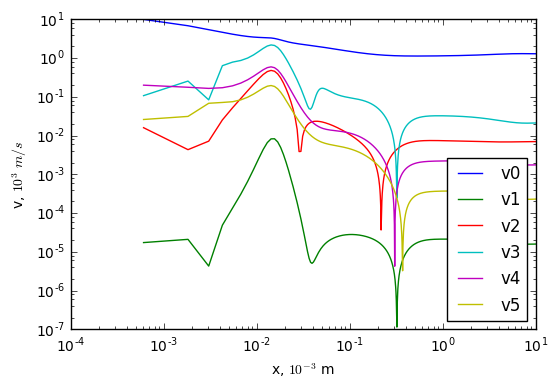

29.5470521359


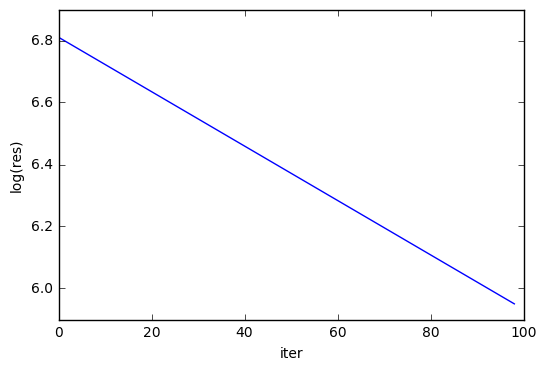

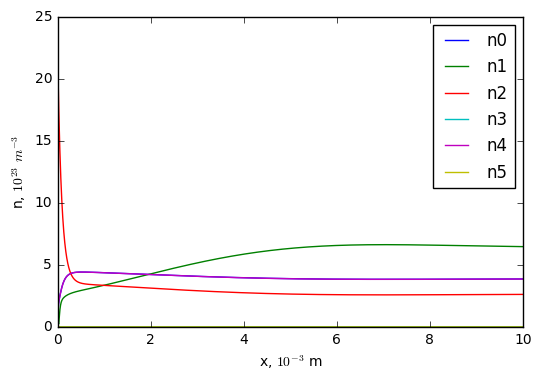

100


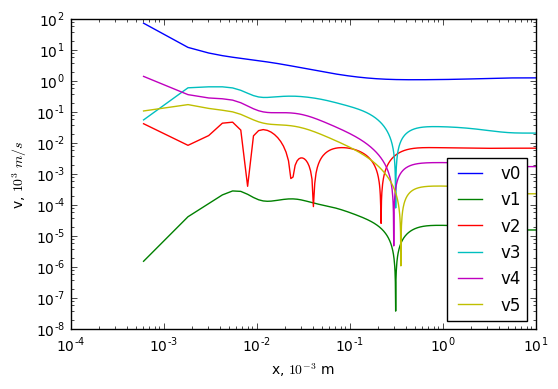

60.6769523164


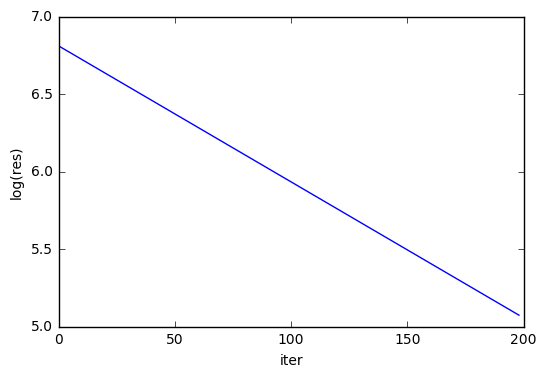

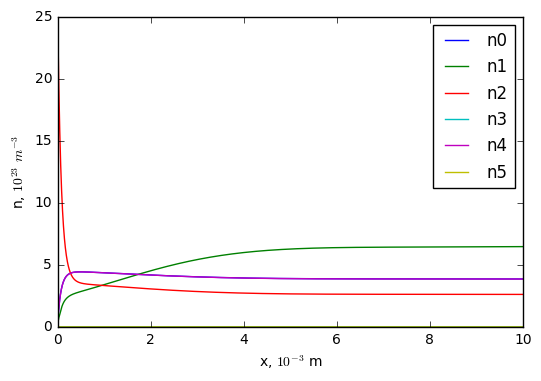

200


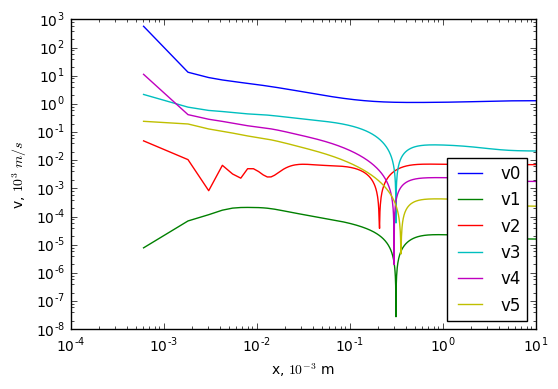

91.6049896224


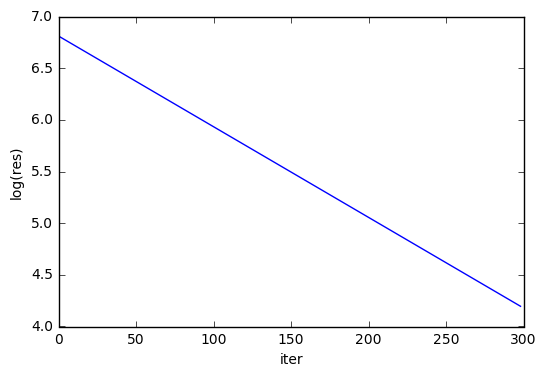

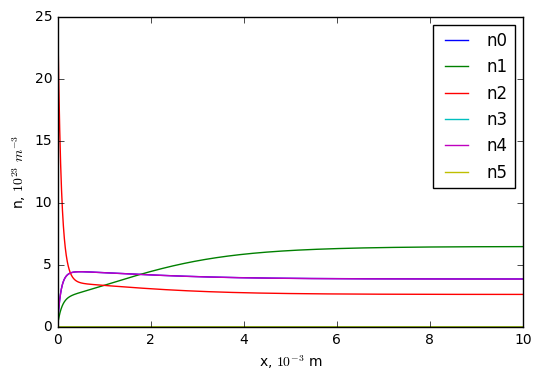

300


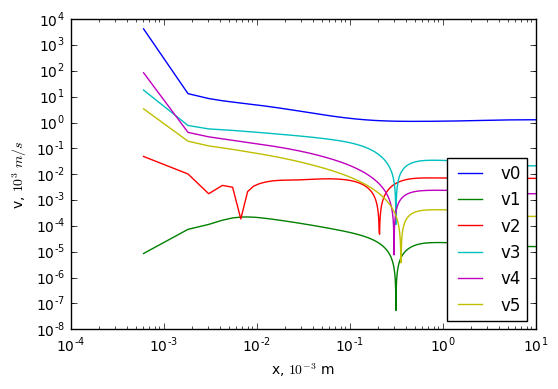

122.200090597


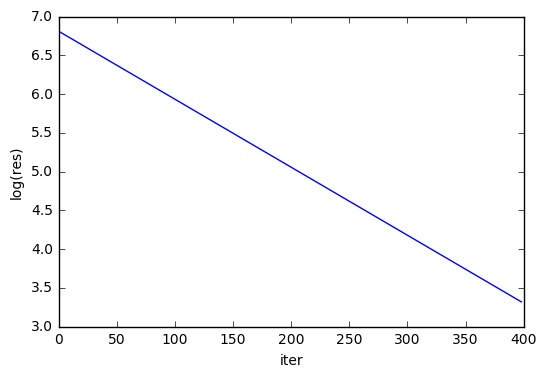

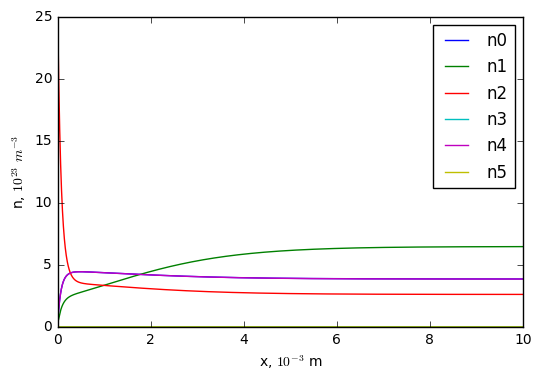

400


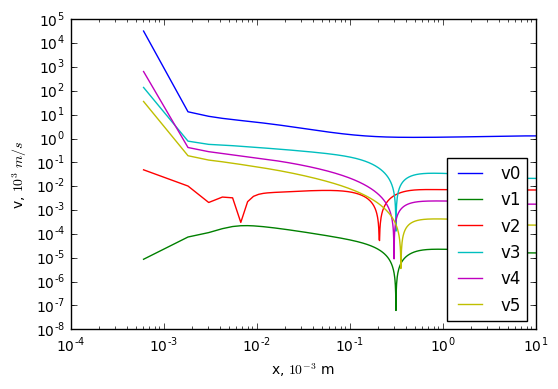

152.87569656


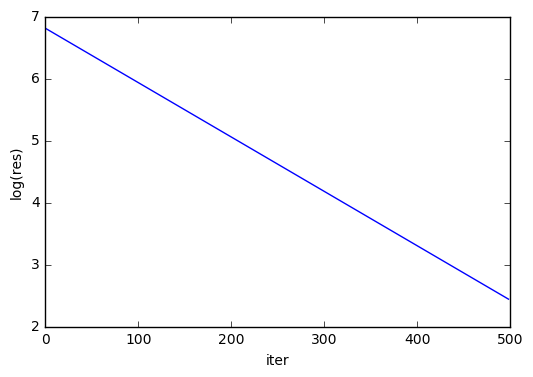

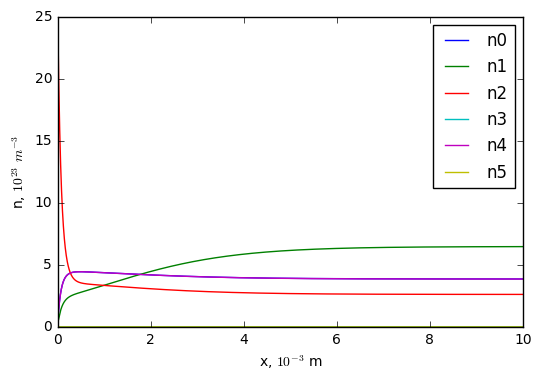

500


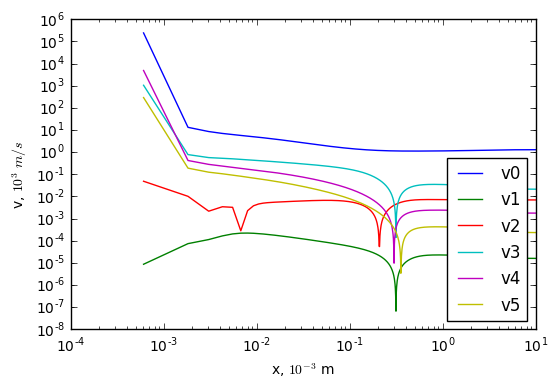

184.358589343


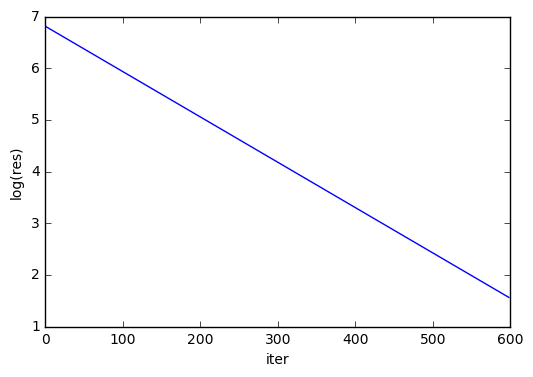

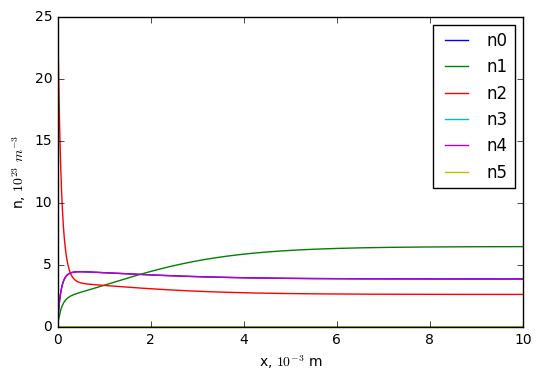

600


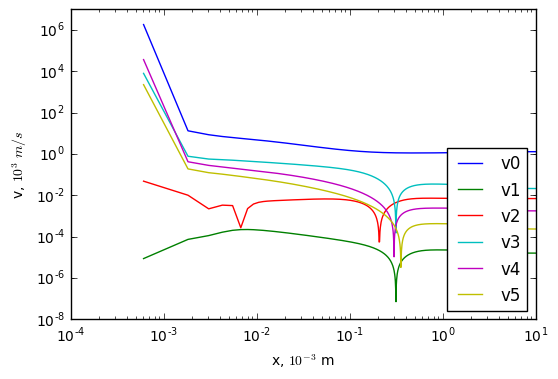

216.188928838


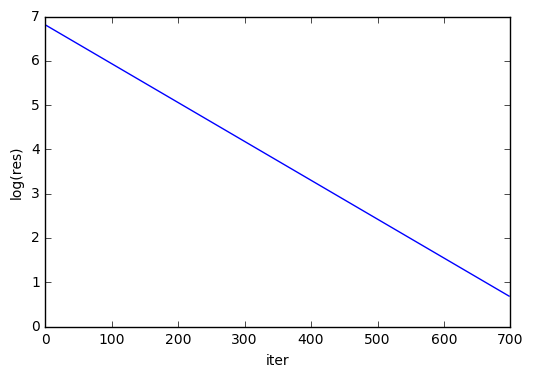

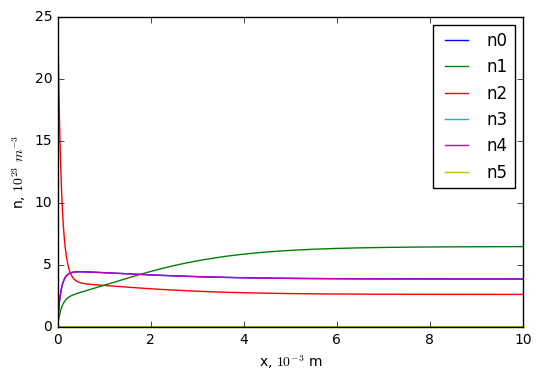

700


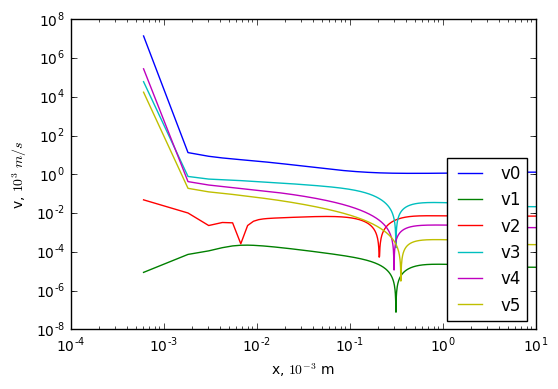

246.999028256


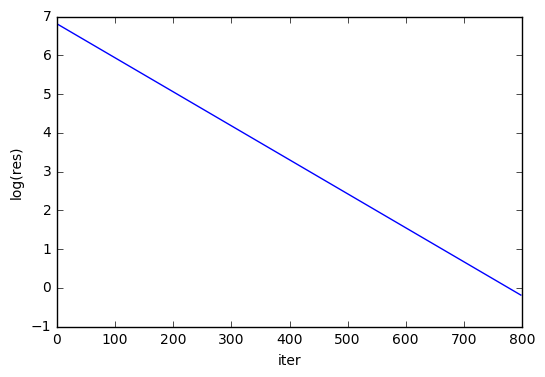

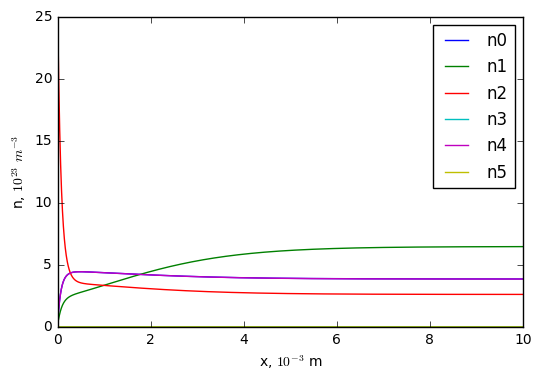

800


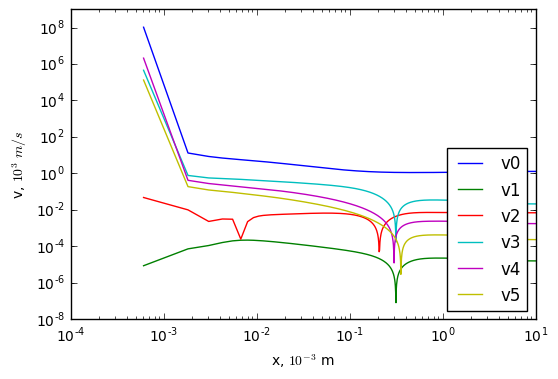

277.515530407


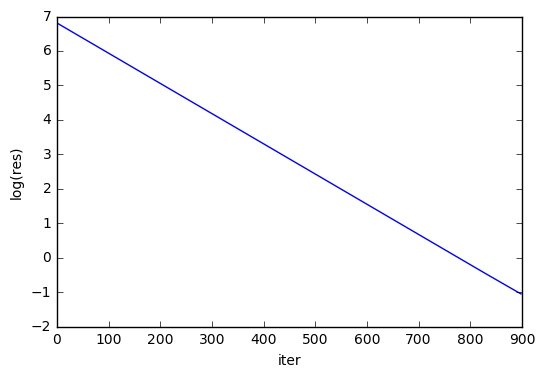

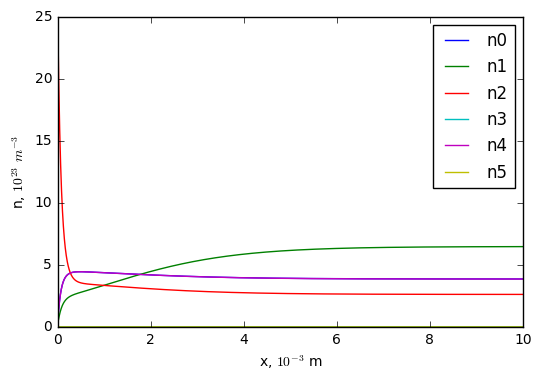

900


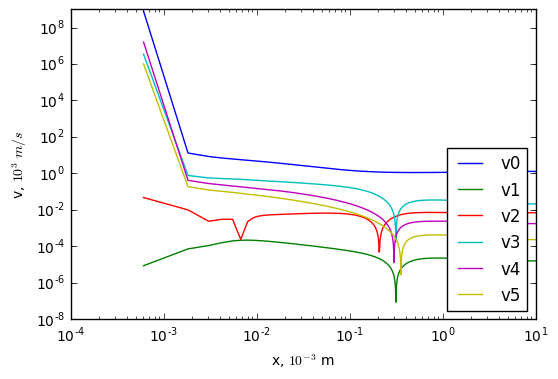

307.755971466


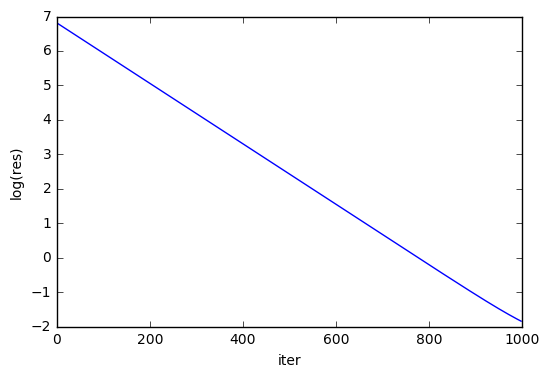

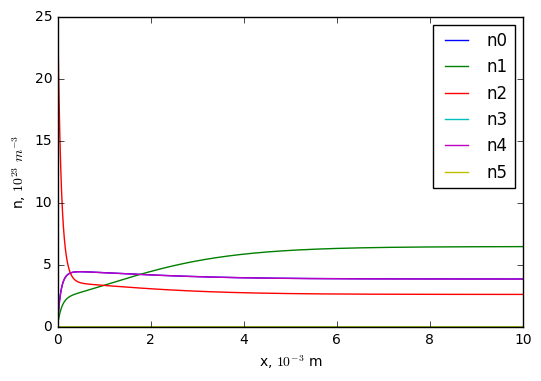

1000


KeyboardInterrupt: 

In [258]:
GNsolver(1025)        
